## Face Detection with HOG

We aim to create a face detection model using HOG features.
To achieve this, we must do the following:
- First we need to create a dataset, that maps HOG features of images to a label, the label should be 1 if there is a face and zero if not.
- Then a classifier need to be trained on this data, to map features to labels with acceptable accuracy (which we need somwhere like 99 percent accurate ...).
- Once the classifier is created, for testing, an image shall be scanned with a sliding window in different scales, HOG features are extracted from each window and then passed to the classifier, windows with an acceptable score will then undergo NMS and the result if finally plotted.

In [1]:
import numpy as np
import itertools
from sklearn.svm import SVC
from cv2 import imread
import matplotlib.pyplot as plt

from data_utils import *
from classifier_utils import *
from visual_utils import *
from test_utils import *

### Step 1: Getting the data.
For the positive dataset, we used the given dataset, assumed to be extracted in the working directory of this file.

For the negative dataset, the [CalTech data set](https://drive.google.com/file/d/1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK/view), most of the classes do not feature human faces and thus are acceptable, though some of them do, we accept this as a bit of an error, because it's just a minority.

Two different functions are created to get the positive and negative images, before starting, we need to decide on the HOG feature parameters, our tests yielded the following.

- In order to get an acceptable amount of performance time, HOG features must not exceed 10000 features, given the number of samples that we shall use (about 5000 was proven to be enough), the training time will be way too much and a risk of overfitting will also be present.

- The HOG descriptor in OpenCV can interpolate HOG features in differnt windows of an image, so they can actually get HOG descriptors out of images that are larger than that window size (this is done be sliding a window and interpolating the results), in our test, **this was seen to strictly make the results worse**, so we opt to input images with exactly the size of the window (thus we have no choice but to scale the positive image dataset to the window size).

- For negative images, as per the instructions of the HW, we need to crop images from the given dataset, in order to keep the data in the same scale of the images, we chose to rescale negative images to the size of positive images (about 256 by 256) and then crop it to the size of the HOG window, this proved to yield much better results than just cropping right away.

The final results of our tests on the HOG descriptor parameters are the following:
- The window size should not be too small (lest the rescaling of the images causes them to become blurry) and it should not be too big, a size of 128 yielded good results.

- The cell size was kept at 8, smaller would make for more data and more would make the features bad.

- Number of bins was fixed at 9, it was never used as hyper parameter, because the fine tuning would become too difficult.

- The block size and block stride were chosen such that they would fulfil the above criterion on the number of features, given that they have to be multiples of the cell size, we have:

$$
\text{block size } := b . \text{cell size} = 8b \\
\text{block stride } := s . \text{cell size} = 8s \\
\text{number of blocks } := (\frac{128 - 8b}{8s} + 1)^2 = (\frac{16 - b}{s} + 1)^2 \\
\text{number of features } = 9 \times (\frac{16 - b}{s} + 1)^2 \times b^2 \le 10000  \\
$$

The solution that we chose was $s=1$ and $b=2$, which gives us 8100 fatures.

One final note, the process time for 20000 train features was way too much, considering that it was possible to get good results with less samples, we opted to use smaller samples, our final choice was:

- 3000 train samples.
- 1000 test samples.
- 1000 validation samples.

For both negative and positive features (thus double these number are actually consumed).

In [2]:
# Loading positive dataset
train, test, val = prepare_positive(get_image_hog, './lfw', 3000, 1000, 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 221.44it/s]


In [3]:
# Loading negative dataset
neg_train, neg_test, neg_val = prepare_negative(
    get_image_hog, './256_ObjectCategories/', 3000, 1000, 1000
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.37it/s]


To prepare the training data, we must:
- Stack the positive and negative training data (we get a total 10000 by 8100 by 1 array)
- Squeeze out the 1 dimension in the end
- Create labels, 1 for face data and 0 for the other.
- Shuffle the data to get a uniform label distribution.

In [4]:
train_data = np.squeeze(np.vstack((train, neg_train)))
test_data = np.squeeze(np.vstack((test, neg_test)))
val_data = np.squeeze(np.vstack((val, neg_val)))

train_label = np.hstack((np.ones((3000,)), np.zeros((3000,))))
test_label = np.hstack((np.ones((1000,)), np.zeros((1000,))))
val_label = np.hstack((np.ones((1000,)), np.zeros((1000,))))

In [5]:
indices_train = np.arange(len(train_data))
indices_test = np.arange(len(test_data))
indices_val = np.arange(len(val_data))

np.random.shuffle(indices_train)
np.random.shuffle(indices_test)
np.random.shuffle(indices_val)

In [6]:
train_data = train_data[indices_train]
test_data = test_data[indices_test]
val_data = val_data[indices_val]

train_label = train_label[indices_train]
test_label = test_label[indices_test]
val_label = val_label[indices_val]

In [7]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (6000, 8100)
Test data shape: (2000, 8100)
Validation data shape: (2000, 8100)


This process is not a fast one, we saved the results for later use.

In [8]:
# np.save('train_data.npy', train_data)
# np.save('train_label.npy', train_label)
# np.save('test_data.npy', test_data)
# np.save('test_label.npy', test_label)
# np.save('val_data.npy', val_data)
# np.save('val_label.npy', val_label)

In [2]:
# train_data = np.load('train_data.npy')
# train_label = np.load('train_label.npy')
# test_data = np.load('test_data.npy')
# test_label = np.load('test_label.npy')
# val_data = np.load('val_data.npy')
# val_label = np.load('val_label.npy')

### Choosing a classifier.
The SVM classifier can also be fine tuned, we chose these parameters to tune.
- The kernel, which is one of *poly*, *rbf*, *linear* or *sigmoid*.
- The degree of the polynomial kernel, chosen from 3, 4, 5 and 6
- The gamma attribute, either *auto* or *scale*.

In [10]:
results = evaluate_params(
    train_data, 
    train_label, 
    val_data,
    val_label,    
    poly_degree = [3, 4, 5, 6], 
    kernel=['rbf', 'linear', 'sigmoid'],
    gamma=['scale', 'auto']
)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Final score: 0.992


  7%|█████▊                                                                            | 1/14 [01:43<22:22, 103.28s/it]

Final score: 0.9855


 14%|███████████▋                                                                      | 2/14 [05:19<33:59, 169.96s/it]

Final score: 0.9945


 21%|█████████████████▌                                                                | 3/14 [05:59<20:14, 110.40s/it]

Final score: 0.9945


 29%|███████████████████████▋                                                           | 4/14 [06:38<13:43, 82.37s/it]

Final score: 0.8755


 36%|█████████████████████████████▋                                                     | 5/14 [08:28<13:51, 92.34s/it]

Final score: 0.984


 43%|███████████████████████████████████▏                                              | 6/14 [13:35<22:00, 165.12s/it]

Final score: 0.9935


 50%|█████████████████████████████████████████                                         | 7/14 [14:47<15:43, 134.81s/it]

Final score: 0.9705


 57%|██████████████████████████████████████████████▊                                   | 8/14 [24:13<27:13, 272.17s/it]

Final score: 0.9935


 64%|████████████████████████████████████████████████████▋                             | 9/14 [25:41<17:52, 214.59s/it]

Final score: 0.9725


 71%|█████████████████████████████████████████████████████████▊                       | 10/14 [34:19<20:32, 308.12s/it]

Final score: 0.9905


 79%|███████████████████████████████████████████████████████████████▋                 | 11/14 [35:44<11:59, 239.98s/it]

Final score: 0.959


 86%|█████████████████████████████████████████████████████████████████████▍           | 12/14 [43:49<10:28, 314.34s/it]

Final score: 0.99


 93%|███████████████████████████████████████████████████████████████████████████▏     | 13/14 [45:30<04:09, 249.79s/it]

Final score: 0.9125


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [53:43<00:00, 230.27s/it]


As you can see, the a few classifiers had the best results, these classifiers correspond to the *linear* kernel with *gamma* as *scale* and the *rbf* kernel with *gamma* as *scale*.

Even though the linear kernel seems to have a higher score, our test resulted in better detection with the rbf kernel ... since the difference is just too small, we can ignore it.

In [4]:
chosen_classifier_params, chosen_classifier = results[0]
print(f"Parameters of the chosen classifier: {chosen_classifier_params}")

Parameters of the chosen classifier: {'kernel': 'rbf', 'gamma': 'scale'}


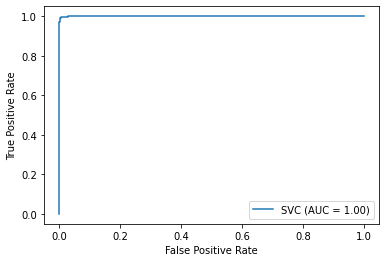

In [5]:
get_roc(chosen_classifier, test_data, test_label)
# plt.savefig('./results/res01.jpg')

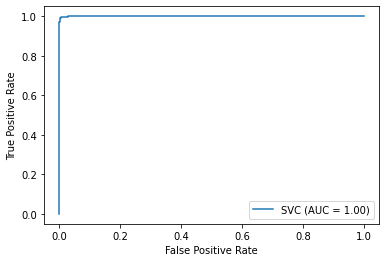

In [6]:
get_percision_recall(chosen_classifier, test_data, test_label)
# plt.savefig('./results/res02.jpg')

### Evaluating the classifier.
For evaluation, we need to use a sliding window algorithm on the given images, to this end we first load the given images, then:
- A window of the same size as the HOG descriptor size is slided with a given stride across the image, each time the HOG descriptor of the window is extrated and saved, the *Anchors* of the window are also saved, which correspond to the upper left and bottom right points of the rectangle that is the current window.
- A score is computed on each window, which signifies how confident we are that this window contains a face (we will get back to this ...).
- Windows with a low score are removed.
- NMS is performed on the remaining windows.

The main concern is, how to assign a number to each window that meaningfully represents the confidence in the window?

One way is to create sklearn classifiers with the *probabilty=True* attribute, the problem is that this makes the classifier VERY slow, a solution can be to use another way to assign such scores, a pretty standad way is with a *Platt scale*.

As you know, SVMs judge the class of a data by using the distance between a given data point and the hyperplane associated with their current weight matrix, thus the distance to the hyperplane is measure of how confident one is in the predicted class of the data, one way to assign a score to this prediction is to pass these values through a logistic function like the following:

$$
\text{score}(l | \text{class}=1) = \frac{1}{1 + exp(-l)}
$$

The larger 'l' is, the higher the score, a score of 0.5 is complete random guess.
All sklearn classifiers output the 'l' value above from a *decision_function* which we shall use to get this score.

In [7]:
meli = cv.imread('resources/Melli.jpg')
perspolise = cv.imread('resources/Persepolis.jpg')
esteghlal = cv.imread('resources/Esteghlal.jpg')

Performing sliding window on images, the first and second images have a scale similar to the HOG window size, so rescaling the image is not needed, the third one however has rather large faces, scaling the photo is required.

In [8]:
nums_meli, anchors_meil = sliding_window(
    chosen_classifier, meli, 128, 1.2, 0, 8, 64
)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [02:16<00:00,  1.61s/it]


In [9]:
nums_perspolis, anchors_perspolis = sliding_window(
    chosen_classifier, perspolise, 128, 1.2, 0, 8, 64
)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.04it/s]


In [10]:
nums_esteghlal, anchors_esteghlal = sliding_window(
    chosen_classifier, esteghlal, 128, 1.5, 3, 8, 64
)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.10it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 13538.10it/s]


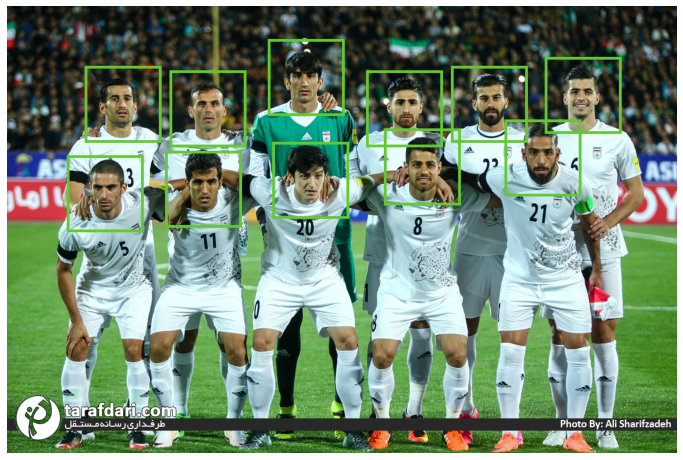

In [11]:
face_plotter(meli, anchors_meil, nums_meli, 0.6, 0.1)
# plt.savefig('./results/res03.jpg')

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 6671.66it/s]


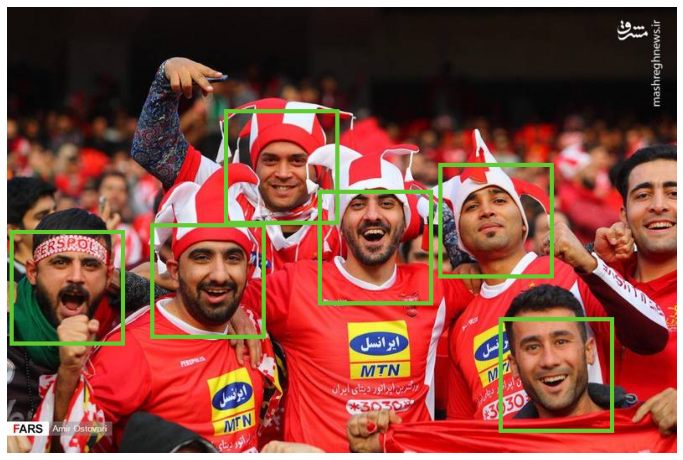

In [12]:
face_plotter(perspolise, anchors_perspolis, nums_perspolis, 0.52, 0.02)
# plt.savefig('./results/res04.jpg')

100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 8276.25it/s]


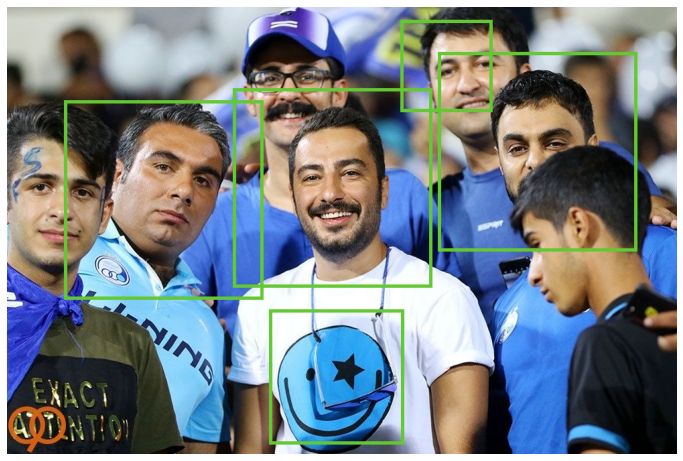

In [13]:
face_plotter(esteghlal, anchors_esteghlal, nums_esteghlal, 0.55, 0.1)
# plt.savefig('./results/res05.jpg')

I am very conflicted that the smiling face on the tshirt of Navid Mohammadzadeh counts as a face or not!
I let it be, since i thought it was interesting :))

#### Some tips on how we got better results
Choosing the score and IoU threshold is a very big part of the final evaluation, the Platt scale is pretty simple to bound however, it is not too sensitive, our guidelines are the following:
- If there are wrong boxes far away from correct ones, increase the score threshold.
- If there are wrong boxes overlapping with correct ones, try decresing the IoU threshold.
- If the faces are very cluttered, you may need to use smaller windows or increase the IoU threshold or decrease the score threshold.
- If the faces are rather large compared to the dimensions of the image, you need to go down a few layers in the Gaussian Pyramid to get a good result ...

A function 'FaceDetector' that does all of these things is also provided, it is assumed that **the classifier is created separately**, this is done because it would be just too hectic and ugly to join these two steps together, however, if no classifier is provided, the algorithm is forced to proceed to create one from scratch (**You are going to wait for quite a while if you do this, you have been warned**)

In [18]:
def FaceDetector(image, win_kwargs, nms_kwargs, classifier=None, training_kwargs=None):
    if classifier:
        print("\n\n" + "*"*10 + " Testing The Classifier " + "*"*10 + "\n\n")
        
        nums, anchors = sliding_window(
            classifier, image, **win_kwargs
        )
    else:
        print("\n\n" + "*"*10 + " Creating Training Dataset " + "*"*10 + "\n\n")
        
        train, test, val = prepare_positive(get_image_hog, './lfw', **training_kwargs)
        neg_train, neg_test, neg_val = prepare_negative(
            get_image_hog, './256_ObjectCategories/', **training_kwargs
        )
        
        train_len, test_len, val_len = list(training_kwargs.values())
        
        train_data = np.squeeze(np.vstack((train, neg_train)))
        test_data = np.squeeze(np.vstack((test, neg_test)))
        val_data = np.squeeze(np.vstack((val, neg_val)))

        train_label = np.hstack((np.ones((train_len,)), np.zeros((train_len,))))
        test_label = np.hstack((np.ones((test_len,)), np.zeros((test_len,))))
        val_label = np.hstack((np.ones((val_len,)), np.zeros((val_len,))))
        
        print("\n\n" + "*"*10 + " Shuffeling Training Dataset " + "*"*10 + "\n\n")

        indices_train = np.arange(len(train_data))
        indices_test = np.arange(len(test_data))
        indices_val = np.arange(len(val_data))

        np.random.shuffle(indices_train)
        np.random.shuffle(indices_test)
        np.random.shuffle(indices_val)
        
        train_data = train_data[indices_train]
        test_data = test_data[indices_test]
        val_data = val_data[indices_val]

        train_label = train_label[indices_train]
        test_label = test_label[indices_test]
        val_label = val_label[indices_val]
        
        print("\n\n" + "*"*10 + " Training A Classifier " + "*"*10 + "\n\n")
        
        results = evaluate_params(
            train_data, 
            train_label, 
            val_data,
            val_label,    
            poly_degree = [], 
            kernel=['rbf'],
            gamma=['scale']
        )
        
        chosen_classifier_params, chosen_classifier = results[0]
        
        print("\n\n" + "*"*10 + " Classifier Evaluation " + "*"*10 + "\n\n")
        
        get_roc(chosen_classifier, test_data, test_label)
        get_percision_recall(chosen_classifier, test_data, test_label)
        
        print("\n\n" + "*"*10 + " Testing The Classifier " + "*"*10 + "\n\n")
        
        classifier = chosen_classifier
        nums, anchors = sliding_window(
            classifier, image, **win_kwargs
        )
        
    face_plotter(image, anchors, nums, **nms_kwargs)

With classifier

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 19712.39it/s]


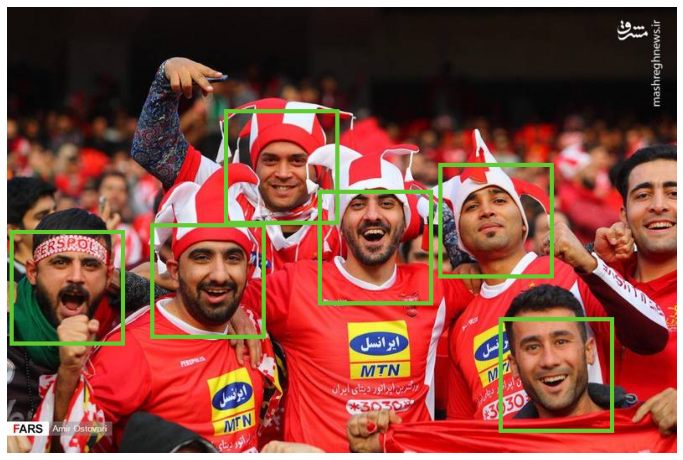

In [17]:
FaceDetector(
    perspolise, 
    win_kwargs={
        'win_size': 128,
        'downscale': 1.2,
        'max_layer': 0,
        'stride_size': 8,
        'batch_size': 64
    },
    nms_kwargs={
        'th': 0.52,
        'iou_th': 0.02
    },
    classifier=chosen_classifier
)

Without classifier (this has been tested with a much smaller dataset to preserve RAM, expect results not as good as above ...)



********** Creating Training Dataset **********




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]



********** Shuffeling Training Dataset **********




********** Training A Classifier **********


Final score: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.48s/it]




********** Classifier Evaluation **********




  0%|                                                                                           | 0/51 [00:00<?, ?it/s]



********** Testing The Classifier **********




100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 15364.97it/s]


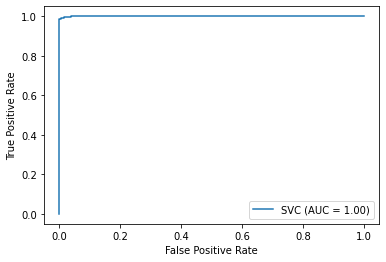

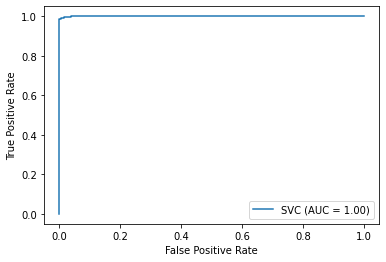

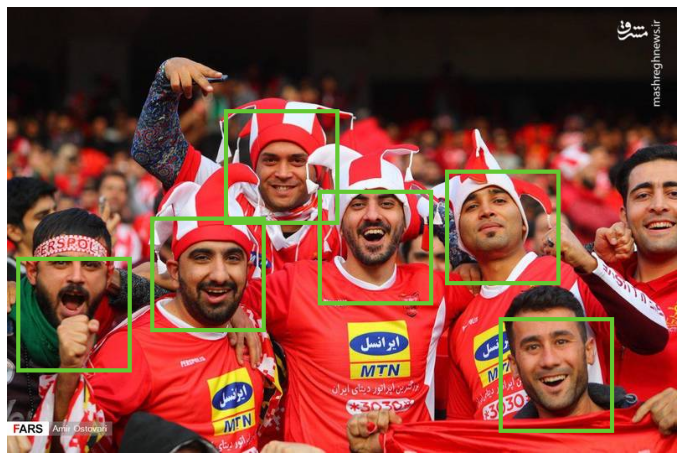

In [21]:
FaceDetector(
    perspolise, 
    win_kwargs={
        'win_size': 128,
        'downscale': 1.2,
        'max_layer': 0,
        'stride_size': 8,
        'batch_size': 64
    },
    nms_kwargs={
        'th': 0.52,
        'iou_th': 0.02
    },
    training_kwargs={
        'num_of_train': 1000,
        'num_of_test': 500,
        'num_of_val': 500
    }
)